In [10]:
import stringphylo
import numpy as np
import pandas as pd
import os

from stringphylo.gp import fit_generic_gpmod, fit_string_gpmod

from skbio.stats.composition import clr, closure, multiplicative_replacement
from gpflow.kernels import Linear
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logging.getLogger("utils").setLevel('INFO')

# Data preparation

The ASV table and phenotypes

In [2]:
# load ASV table and phenotypes
asv_table = pd.read_csv("../data/asv_table.csv").set_index("sample_id")
phenotypes = pd.read_csv("../data/phenotypes.csv").set_index("#SampleID")
common_samples = np.intersect1d(asv_table.index, phenotypes.index)

logger.info(f"ASV table shape: {asv_table.shape}, phenotypes shape: {phenotypes.shape}")
logger.info(f"{common_samples.shape[0]} samples with phenotype and ASV counts")

asv_table = asv_table.loc[common_samples,:]
phenotypes = phenotypes.loc[common_samples,:]

assert np.all(np.isnan(asv_table).sum()==0)
assert np.all(np.isnan(phenotypes).sum()==0)
assert asv_table.shape[0]==phenotypes.shape[0]
assert asv_table.index.equals(phenotypes.index)

2022-12-06 15:59:06 INFO     ASV table shape: (394, 525), phenotypes shape: (388, 1)
2022-12-06 15:59:06 INFO     388 samples with phenotype and ASV counts


# Formatting string kernels

Requires loading the $Q$ matrix for each value of the string kernel hyperparamters. Here we only consider the spectrum kernel with $k$-mer length from 2 to 30.

In [3]:
# load files containing spectrum kernels for these ASVs
def read_feather(filepath):
    out = pd.read_feather(filepath)
    if "rownames" in out:
        return out.set_index("rownames")
    else:
        logger.warning("'rownames' not available for use as index")
        return out.set_index("C0")
    
def parse_stringkernel_name(x):
    return dict([xx.split("__", 1) for xx in x.replace(".feather", "").split("____")]) 
    
kernel_load_path = "../data/ravel_stringkernels"
asv_names = asv_table.columns

# load the string kernel Q matrices
kernel_files = [
    f for f in os.listdir(kernel_load_path)
    if os.path.isfile(os.path.join(kernel_load_path, f))
]
logger.info(f"Found {len(kernel_files)} string kernel files")

loaded_kernels = []
for i, f in enumerate(kernel_files):
    logger.debug(f"Loading kernel {i} of {len(kernel_files)}")
    Q = read_feather(os.path.join(kernel_load_path, f))
    if not Q.columns.equals(Q.index):
        logger.warning(f"Columns and index don't match for {kernel_files[k]}")
        continue
    
    # reorder columns of Q to match the ASV table
    loaded_kernels.append(
        dict({'Q' : Q.loc[asv_names,asv_names].astype(float)}, **parse_stringkernel_name(f))
    )
logger.info(f"Loaded {len(loaded_kernels)} spectrum kernels")

# store in dataframe
kernel_df = pd.DataFrame([{k : v for k,v in x.items() if k!='Q'} for x in loaded_kernels])
kernel_df["Q"] = [x['Q'] for x in loaded_kernels]
kernel_df = kernel_df.drop(columns="dataset")
kernel_df

2022-12-06 15:59:06 INFO     Found 29 string kernel files
2022-12-06 15:59:06 DEBUG    Loading kernel 0 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 1 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 2 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 3 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 4 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 5 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 6 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 7 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 8 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 9 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 10 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 11 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 12 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 13 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 14 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 15 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 16 of 29
2022-12-06 15:59:07 DEBUG    Loading kernel 17 of 2

,type,k,m,r,Q
0,spectrum,9,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
1,spectrum,25,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
2,spectrum,6,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
3,spectrum,26,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
4,spectrum,16,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
5,spectrum,19,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
6,spectrum,4,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
7,spectrum,18,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
8,spectrum,12,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...
9,spectrum,17,NA,1,OTU_0 OTU_1 OTU_10 OTU_10...


# Fitting the GP models

We fit GP models with two different kernels - a spectrum kernel with $k$-mer length from 2 to 30, and an RBF kernel. For the string kernel we can select the value of $k$ that maximises the log-marginal likehlihood.

In [24]:
# apply the CLR transform before computing the kernels
def clr_transform(x):
    return clr(closure(multiplicative_replacement(x)))

# GP fit
NOISE_VAR_STARTING_GUESS = 1.0
SIGNAL_VAR_STARTING_GUESS = 1.0
OPT = True

# The GP model sees the CLR-transformed counts and scaled phenotypes
X = clr_transform(asv_table.to_numpy().astype(float))
y = scale(phenotypes.Var.to_numpy().astype(float))

gp_rbf, _, _ = fit_generic_gpmod(
    X, y,
    lambda: RBF(variance=SIGNAL_VAR_STARTING_GUESS),
    NOISE_VAR_STARTING_GUESS,
    OPT)

# this function will select the best value of k
gp_string, string_lmls, best_hparams = fit_string_gpmod(
    X, y,
    SIGNAL_VAR_STARTING_GUESS,
    NOISE_VAR_STARTING_GUESS,
    OPT,
    kernel_df
)

# Log-marginal likelihood

In a real application we would do a more systematic evaluation of the GP fits, for example using cross-validation.

For this simple example we just check the log-marginal likelihoods for the spectrum kernel with different values of $k$-mer length. The fit improves as the value of $k$ is increased and then plateaus. Any $k$-mer length gives a larger log-marginal likelihood than the RBF kernel (the red horizontal line).

Text(0, 0.5, 'log-marginal likelihood')

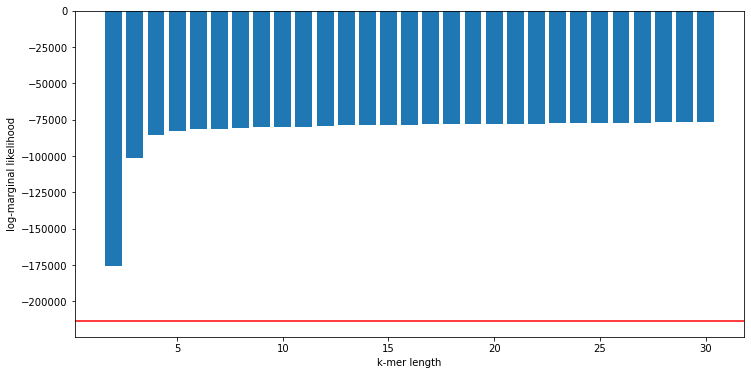

In [30]:
# plot the log-marginal likelhioods
string_lmls_plot = string_lmls.copy()
string_lmls_plot.k = string_lmls_plot.k.astype(int)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x=string_lmls_plot.k, height=string_lmls_plot.lml)
ax.axhline(gp_rbf.log_posterior_density().numpy(), c="red")
ax.set_xlabel("k-mer length")
ax.set_ylabel("log-marginal likelihood")